In [151]:
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
import statsmodels.api as sm


### Logistic Regression via Maximum Likelihood

Model directly the probability $p(y|x)$ for binary data $y \in \{0,1\}$ for some covariates $X$. There is no closed form for the MLE but we can solve approximately with an optimizer

#### Breast Cancer Survival Data

The dataset contains cases from a study that was conducted between
   1958 and 1970 at the University of Chicago's Billings Hospital on
   the survival of patients who had undergone surgery for breast
   cancer.


Four columns 

1. Age of patient at time of operation (numerical)
2. Patient's year of operation (year - 1900, numerical)
3. Number of positive axillary nodes detected (numerical)
4. Survival status (class attribute)
     1 = the patient survived 5 years or longer
     2 = the patient died within 5 year

See more info at the UCI repository [page](https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.names). 

In [152]:
url_hospital = "haberman.csv"
data1 = pd.read_csv(url_hospital, header=None,
        names=['age', 'year', 'nodes_detected', 'survival_status'])
data1.head()

,age,year,nodes_detected,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


Split data for training and test.

In [153]:
# define data and create train test splits
data1['y'] = data1.survival_status.replace(2, 0).values
n = len(data1['y'])
data1['x0'] = np.ones(n)
predictors = ['x0','age','nodes_detected','year']
target = ['y']
X_train, X_test, y_train, y_test = train_test_split(data1[predictors], data1[target],
                        test_size=0.33, random_state=1)
n,p = X_train.shape


#### MLE using an optimizer

The accompanying chapter in **Bishop is 4.3.2**.

In our setting we have a binary (2-class) classification problem with a sample size $n$. Our date consistts of pairs of labels and features $\{(y_1,x_1), \ldots, (y_n,x_n)\}$ where $y_i \in \{0,1\}$ and $x_i \in R^m$. We are interested in the probability $p(y=1|x)$.

The logistic regression model uses the logistic function $\sigma(\cdot) : (-\infty, -\infty) \rightarrow  (0,1) $ (also known as sigmoid)
$$\sigma(x) =\big( \frac{1}{1+e^{-x}} \big)$$


Note that the inverse of the the logistic function $\sigma(\cdot)^{-1}$, in the sense of their composition equaling the identity map, is the logit function $$\text{logit}(a) = \log\big( \frac{a}{1-a} \big)$$

Specifically, in the context of logistic regression, the function we need is the following

$$
\sigma(x, \beta) = \big( \frac{1}{1+e^{-x \beta}} \big)
$$

which we implement below.

In [154]:
def sigma(x,beta):
    d = 1. + np.exp(-x.dot(beta))
    return d**(-1)


The Logistic Regression likelihood is given by the following formula

\begin{align}
p( y=1| \beta,x) &= \prod_{i=1}^n f(x_n,\beta)^{y_n} \cdot [1-f(x_n,\beta)]^{(1-y_n)} \\
&= \prod_{i=1}^n f_n^{y_n} \cdot (1-f_n)^{(1-y_n)} \\
\end{align}

where we define for convenience of notation $f_n := f(x_n,\beta)$ .

Hence the negative log-likelihood (NLL) becomes
\begin{align}
\log p( y=1| \beta,x) &= \sum_{i=1}^n \{ y_n \log f_n + (1-y_n) \log(1-f_n) \}
\end{align}
which we code as a function below

In [155]:
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t

Next we will find the MLE by minimising the negagive log-likelihood using the **Newton-Raphson** algorithm. This algorithm required the gradient ($f^{\prime}$) and the Hessian matrix. Below we provide these functions.

In [156]:
#function to find Hessian
def fprime(beta,x,y):
    return  x.T.dot(sigma(x,beta)-y)
def Hessian(beta,x):  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    hes = x.T.dot(S.dot(x))
    return hes
def NewtonRaphsonLogistReg(beta0,x,y,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogLike = nll(beta,x,y)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log likelihood ',NegLogLike, ' AbDiff ', AbDiff)
        grad = fprime(beta,x,y)
        H = Hessian(beta,x)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogLike_new = nll(beta,x,y)
        AbDiff = np.abs(NegLogLike_new-NegLogLike)
        NegLogLike = NegLogLike_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

Now, apply these functions to our data to obtain the coefficents of MLE.

In [157]:
predictors = ['x0', 'age','nodes_detected']
X = X_train[predictors]
n,p = X.shape
y = y_train['y']
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_mle, cov = NewtonRaphsonLogistReg(beta0, X, y, maxiter, tolerance)

iteration  1  Negative Log likelihood  142.0951720147888  AbDiff  1
iteration  2  Negative Log likelihood  109.3606912701201  AbDiff  32.7344807446687
iteration  3  Negative Log likelihood  108.78065092148668  AbDiff  0.5800403486334176
iteration  4  Negative Log likelihood  108.77859955619097  AbDiff  0.002051365295713481


We will also compute 95% confidence intervals by using the Hessian which is the inverse of the MLE covariance. We will present the results via a pandas data frame

In [158]:
#Invert for the covariance and find 95% CIs
#cov = sc.linalg.inv(H)
se = np.sqrt(np.diag(cov))
lower95 = beta_mle - 1.96*se
upper95 = beta_mle + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_mle,se,lower95,upper95])
col = ['coefficient','se','lower 95% bound','upper 95% bound']
ind = ['intercept','age','nodes_detected']
results = pd.DataFrame(results,columns = col,index=ind)
results

,coefficient,se,lower 95% bound,upper 95% bound
intercept,0.881483,0.862600,-0.809214,2.572179
age,0.010840,0.016164,-0.020841,0.042521
nodes_detected,-0.101423,0.026230,-0.152833,-0.050013


To confirm we got it right we will also check with the function Logit from the statsmodels library

In [159]:
predictors = ['age','nodes_detected']
Xt = X_train[predictors]
Xt = sm.add_constant(Xt)
yt = y_train['y']
model = sm.Logit(yt, Xt).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.530627
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  205
Model:                          Logit   Df Residuals:                      202
Method:                           MLE   Df Model:                            2
Date:                Wed, 23 Nov 2022   Pseudo R-squ.:                 0.07973
Time:                        17:40:21   Log-Likelihood:                -108.78
converged:                       True   LL-Null:                       -118.20
Covariance Type:            nonrobust   LLR p-value:                 8.076e-05
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8815      0.863      1.022      0.307      -0.809       2.572
age                0.0108      0.016      0.671      0.502      -0.021       0.043
nodes_detected    -0.1014      0.026     -3.867      0.000      -0.153      -0.050
==================================================================================
"""

The function LogisticRegression from sklearn can also be used. It is more robust and efficient for large datasets

In [160]:
predictors = ['age','nodes_detected']
Xt = X_train[predictors]
logreg = LogisticRegression(fit_intercept=True,solver='lbfgs')
logreg.fit(Xt,yt)
intercept = np.array([logreg.intercept_])[0,]
coef = np.array(logreg.coef_)[0,].T
beta_mle = np.hstack((intercept,coef))
print(beta_mle)


[ 0.8813341   0.01083727 -0.10135341]


### Laplace Approximation (Bishop 4.5)

Bayesian Logistic Regression is not availabe in a closed form. One method is to use a Laplace approximation according to which we approximate the posterior $p(\beta | x, y)$ with a Gaussian. The Gaussian distribution is characterised by two parameters, the mean and the covariance. The mean $\beta_{\text{MAP}}$ is given by the MAP of the unormalized likelihood times prior, while the covariance is the Hessian evaluated $\beta_{\text{MAP}}$. 

The posterior is given by equation 4.141 and 4.142 which we implement below

Assume a Gaussian prior and get the following approximate posterior 

\begin{align}
\beta & \sim N(m_0, S_0^{-1}) \; \text{(prior)}\\
p(\beta|x,y) & \sim  N(\hat{\beta}, S^{-1})  \; \text{(posterior)}
\end{align}

where
\begin{align}
\beta_{\text{MAP}} & = \text{argmin}_{\beta} \log p(\beta|y,x), \; \log p(\beta|y,x) = \log p(y|\beta,x) + \log p(\beta) \\
S & = -\nabla^2 \log p(\beta|y,x) |_{\beta_{\text{MAP}}}
\end{align}

In [161]:
def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y)+S0.dot(beta-m0)
def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec
def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [162]:
predictors = ['x0','age','nodes_detected']
Xt = X_train[predictors]
n,p = Xt.shape
m0 = np.zeros(p)
S0 = Xt.T.dot(Xt)/n
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,Xt, y_train['y'],
                                                  m0,S0,maxiter,tolerance)
print(beta_map)
cov

iteration  1  Negative Log Posterior  142.0951720147888  AbDiff  1
iteration  2  Negative Log Posterior  110.07931941344913  AbDiff  32.015852601339674
iteration  3  Negative Log Posterior  109.57914415842247  AbDiff  0.5001752550266616
iteration  4  Negative Log Posterior  109.57778845744727  AbDiff  0.0013557009751963278
[ 0.86367753  0.01035354 -0.09807053]


array([[ 7.10946923e-01, -1.29492538e-02, -2.77955038e-03],
       [-1.29492538e-02,  2.49096668e-04,  1.74790814e-06],
       [-2.77955038e-03,  1.74790814e-06,  6.54412084e-04]])

In [163]:
#95% credible intervals
se = np.sqrt(np.diag(cov))
lower95 = beta_map - 1.96*se
upper95 = beta_map + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_map,se,lower95,upper95])
col = ['post mean','post se','lower 95% bound','upper 95% bound']
ind = ['intercept','age','nodes_detected']
results = pd.DataFrame(results,columns = col,index=ind)
results

,post mean,post se,lower 95% bound,upper 95% bound
intercept,0.863678,0.843177,-0.788949,2.516304
age,0.010354,0.015783,-0.020581,0.041288
nodes_detected,-0.098071,0.025581,-0.148210,-0.047931


### Activity 1

Consider the model that also has the variable year as a covariate. Provide the ouput from the MLE and Bayesian (via Laplace approximation) approaches. 

### Answer

Put your code below

In [164]:
predictors = ['x0','age','nodes_detected', 'year']
Xt = X_train[predictors]
n,p = Xt.shape
m0 = np.zeros(p)
S0 = Xt.T.dot(Xt)/n
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,Xt, y_train['y'],
                                                  m0,S0,maxiter,tolerance)

#95% credible intervals
se = np.sqrt(np.diag(cov))
lower95 = beta_map - 1.96*se
upper95 = beta_map + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_map,se,lower95,upper95])
col = ['post mean','post se','lower 95% bound','upper 95% bound']
ind = ['intercept','age','nodes_detected', 'year']
results = pd.DataFrame(results,columns = col,index=ind)
results

iteration  1  Negative Log Posterior  142.0951720147888  AbDiff  1
iteration  2  Negative Log Posterior  109.89202949052206  AbDiff  32.20314252426674
iteration  3  Negative Log Posterior  109.36716255058096  AbDiff  0.5248669399411057
iteration  4  Negative Log Posterior  109.36560794841178  AbDiff  0.0015546021691790202


,post mean,post se,lower 95% bound,upper 95% bound
intercept,2.869386,3.197866,-3.398432,9.137204
age,0.011558,0.015924,-0.019653,0.042768
nodes_detected,-0.096766,0.025600,-0.146941,-0.046590
year,-0.032950,0.050625,-0.132174,0.066274


### Evaluate predictive performance for Logistic regression

In [165]:
#Calculate model evidence and BIC
predictors = ['x0','age','nodes_detected', 'year']
Xt = X_train[predictors]
n,p = Xt.shape
logEv = -neg_post(beta_map, Xt, y_train, m0, S0) + (p/2)*np.log(2*np.pi) + (1/2)*np.log(sc.linalg.det(cov))
BIC = -nll(beta_map, Xt, y_train) -(p/2)*np.log(n)
logEv, BIC

(y   -118.297484
 dtype: float64,
 y   -119.227327
 dtype: float64)

iteration  1  Negative Log likelihood  142.0951720147888  AbDiff  1
iteration  2  Negative Log likelihood  109.16795352220011  AbDiff  32.92721849258869
iteration  3  Negative Log likelihood  108.55913096132062  AbDiff  0.6088225608794886
iteration  4  Negative Log likelihood  108.55677521560668  AbDiff  0.0023557457139418148
0.7227722772277227 y    59.437452
dtype: float64
0.7227722772277227 59.43745216191007
0.5813313313313314


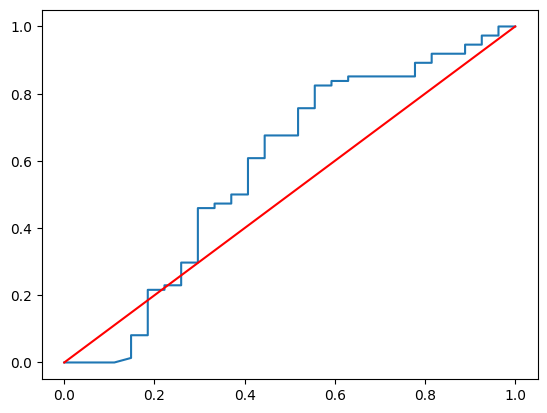

In [166]:
#prediction assessment for MLE approach

beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_mle, cov = NewtonRaphsonLogistReg(beta0, Xt, y, maxiter, tolerance)

predict_probs = sigma(X_test[predictors],beta_mle)
predict_class = (predict_probs > .5)

AccRate_MLE = np.sum(predict_class==y_test['y'])/len(y_test) 
LS_MLE = -(y_test.T.dot(np.log(predict_probs))+(1-y_test).T.dot(np.log(1-predict_probs)))

print(AccRate_MLE, LS_MLE)
print(accuracy_score(y_test,predict_class), log_loss(y_test, predict_probs, normalize=False))

fpr,tpr,thresholds = roc_curve(y_test,predict_probs)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC_MLE = roc_auc_score(y_test,predict_probs)
print(AUC_MLE)

iteration  1  Negative Log Posterior  142.0951720147888  AbDiff  1
iteration  2  Negative Log Posterior  109.89202949052206  AbDiff  32.20314252426674
iteration  3  Negative Log Posterior  109.36716255058096  AbDiff  0.5248669399411057
iteration  4  Negative Log Posterior  109.36560794841178  AbDiff  0.0015546021691790202


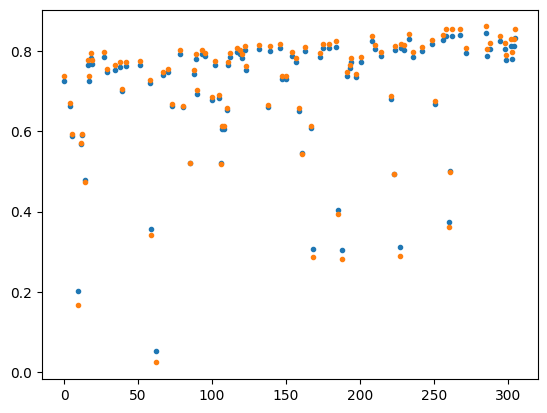

In [167]:
#Calculate the prediction probabilities with Bayesian Logistic regression
m0 = np.zeros(p)
S0 = Xt.T.dot(Xt)/n
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,Xt, y_train['y'],
                                                  m0,S0,maxiter,tolerance)

N = 10000 #number of Monte Carlo samples
# draw N samples from the approximate posterior (Laplace) of beta
betas = np.random.multivariate_normal(beta_map,cov,N)
Xbetas = X_test[predictors].dot(betas.T)
#apply sigmoid
d = 1/(1. + np.exp(-Xbetas))
pred_probs_blr = np.mean(d, axis=1)
plt.plot(pred_probs_blr,'.')
plt.plot(predict_probs,'.')

0.7128712871287128 y    58.788624
dtype: float64 0.5828328328328329
0.7227722772277227 y    59.437452
dtype: float64 0.5813313313313314


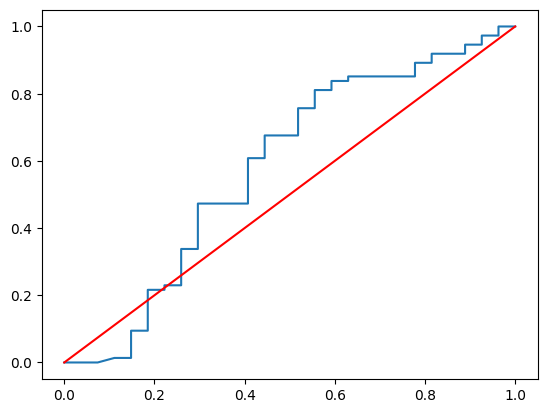

In [168]:
#Evaluate predictive performance of Bayesian Logistic Regression

pred_class_blr = (pred_probs_blr > .5)

AccRate = np.sum(pred_class_blr==y_test['y'])/len(y_test) 
LS = -(y_test.T.dot(np.log(pred_probs_blr))+(1-y_test).T.dot(np.log(1-pred_probs_blr)))

fpr,tpr,thresholds = roc_curve(y_test,pred_probs_blr)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr)
plt.plot(xgrid,xgrid,'red')
AUC = roc_auc_score(y_test,pred_probs_blr)
print(AccRate, LS, AUC)
print(AccRate_MLE, LS_MLE, AUC_MLE)

### Activity 2

Consider 2 logistic regression models: 

 - M1: with covariates *age* and *nodes detected*.
 - M2: with covariates *year*, *age* and *nodes detected*.
 
  a. Compare them using the log-evidence, the BIC, the area under the ROC curve and the log scoring rule.
  
  b. Discuss the differences in predicted probabilities from MLE and Bayesian models.

### Answer

Put your code below

iteration  1  Negative Log Posterior  142.0951720147888  AbDiff  1
iteration  2  Negative Log Posterior  110.66720281116204  AbDiff  31.42796920362676
iteration  3  Negative Log Posterior  110.10982512303562  AbDiff  0.5573776881264223
iteration  4  Negative Log Posterior  110.10813194621146  AbDiff  0.0016931768241619238
iteration  1  Negative Log Posterior  142.0951720147888  AbDiff  1
iteration  2  Negative Log Posterior  110.27822155009378  AbDiff  31.816950464695026
iteration  3  Negative Log Posterior  109.77139754440427  AbDiff  0.5068240056895092
iteration  4  Negative Log Posterior  109.76995096408577  AbDiff  0.0014465803185004233
M1 log-evidence and BIC
y   -117.719089
dtype: float64 y   -114.65456
dtype: float64
M2 log-evidence and BIC
y   -120.784789
dtype: float64 y   -116.981845
dtype: float64
iteration  1  Negative Log likelihood  142.0951720147888  AbDiff  1
iteration  2  Negative Log likelihood  109.95583642555286  AbDiff  32.13933558923594
iteration  3  Negative Log 

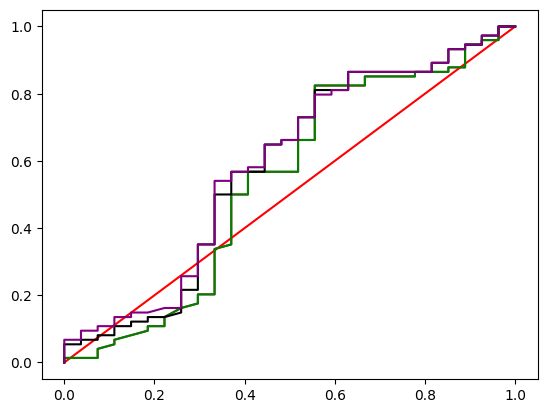

In [169]:
predictors1 = ['age', 'nodes_detected']
predictors2 = ['year', 'age','nodes_detected']
X1 = X_train[predictors1]
X2 = X_train[predictors2]
tolerance = 1e-05
maxiter = 100

# log-evidence, BIC
n1,p1 = X1.shape
m1 = np.zeros(p1)
S1 = X1.T.dot(X1)/n1
beta1 = np.zeros(p1)
beta_map1, cov1 = NewtonRaphsonBayesLogReg(beta1,X1, y_train['y'],
                                                  m1,S1,maxiter,tolerance)
logEv1 = -neg_post(beta_map1, X1, y_train, m1, S1) + (p1/2)*np.log(2*np.pi) + (1/2)*np.log(sc.linalg.det(cov1))
BIC1 = -nll(beta_map1, X1, y_train) -(p1/2)*np.log(n1)

n2,p2 = X2.shape
m2 = np.zeros(p2)
S2 = X2.T.dot(X2)/n2
beta2 = np.zeros(p2)
beta_map2, cov2 = NewtonRaphsonBayesLogReg(beta2,X2, y_train['y'],
                                                  m2,S2,maxiter,tolerance)
logEv2 = -neg_post(beta_map2, X2, y_train, m2, S2) + (p2/2)*np.log(2*np.pi) + (1/2)*np.log(sc.linalg.det(cov2))
BIC2 = -nll(beta_map2, X2, y_train) -(p2/2)*np.log(n2)

print('M1 log-evidence and BIC')
print(logEv1, BIC1)
print('M2 log-evidence and BIC')
print(logEv2, BIC2)

# M1 use MLE
beta_mle1, cov_mle1 = NewtonRaphsonLogistReg(beta1, X1, y, maxiter, tolerance)
predict_probs1 = sigma(X_test[predictors1],beta_mle1)
predict_class1 = (predict_probs1 > .5)
AccRate_MLE1 = np.sum(predict_class1==y_test['y'])/len(y_test) 

# log scoring rule in MLE
LS_MLE1 = -(y_test.T.dot(np.log(predict_probs1))+(1-y_test).T.dot(np.log(1-predict_probs1)))


# M1 use Bayesian models
N = 10000
betas1 = np.random.multivariate_normal(beta_map1,cov1,N)
Xbetas1 = X_test[predictors1].dot(betas1.T)
d1 = 1/(1. + np.exp(-Xbetas1))
pred_probs_blr1 = np.mean(d1, axis=1)
pred_class_blr1 = (pred_probs_blr1 > .5)
AccRate_B1 = np.sum(pred_class_blr1==y_test['y'])/len(y_test) 

# log scoring rule in Bayesian
LS_B1 = -(y_test.T.dot(np.log(pred_probs_blr1))+(1-y_test).T.dot(np.log(1-pred_probs_blr1)))

# draw figure
# roc cureve
fpr_MLE1,tpr_MLE1,thresholds_MLE1 = roc_curve(y_test,predict_probs1)
fpr_B1,tpr_B1,thresholds_B1 = roc_curve(y_test,pred_probs_blr1)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr_MLE1,tpr_MLE1, 'brown')
plt.plot(xgrid,xgrid, 'red')
plt.plot(fpr_B1,tpr_B1, 'green')

# M1: area under roc curve
AUC_MLE1 = roc_auc_score(y_test,predict_probs1)
AUC_B1 = roc_auc_score(y_test,pred_probs_blr1)
print('M1 log scoring rule and area under roc curve')
print('MLE')
print(LS_MLE1, AUC_MLE1)
print('Bayesian')
print(LS_B1, AUC_B1)


# M2 use MLE
beta_mle2, cov_mle2 = NewtonRaphsonLogistReg(beta2, X2, y, maxiter, tolerance)
predict_probs2 = sigma(X_test[predictors2],beta_mle2)
predict_class2 = (predict_probs2 > .5)
AccRate_MLE2 = np.sum(predict_class2==y_test['y'])/len(y_test) 

# log scoring rule in MLE
LS_MLE2 = -(y_test.T.dot(np.log(predict_probs2))+(1-y_test).T.dot(np.log(1-predict_probs2)))


# M2 use Bayesian models
N = 10000
betas2 = np.random.multivariate_normal(beta_map2,cov2,N)
Xbetas2 = X_test[predictors2].dot(betas2.T)
d2 = 1/(1. + np.exp(-Xbetas2))
pred_probs_blr2 = np.mean(d2, axis=1)
pred_class_blr2 = (pred_probs_blr2 > .5)
AccRate_B2 = np.sum(pred_class_blr2==y_test['y'])/len(y_test) 

# log scoring rule in Bayesian
LS_B2 = -(y_test.T.dot(np.log(pred_probs_blr2))+(1-y_test).T.dot(np.log(1-pred_probs_blr2)))

# draw figure

# roc cureve
fpr_MLE2,tpr_MLE2,thresholds_MLE2 = roc_curve(y_test,predict_probs2)
fpr_B2,tpr_B2,thresholds_B2 = roc_curve(y_test,pred_probs_blr2)
plt.plot(fpr_MLE2,tpr_MLE2, 'black')
plt.plot(fpr_B2,tpr_B2, 'purple')

# M2 area under roc curve
AUC_MLE2 = roc_auc_score(y_test,predict_probs2)
AUC_B2 = roc_auc_score(y_test,pred_probs_blr2)

print('M2 log scoring rule and area under roc curve')
print('MLE')
print(LS_MLE2, AUC_MLE2)
print('Bayesian')
print(LS_B2, AUC_B2)


### Linear Discriminant Analysis

Compute the classification probability $p(y=1|x)$ by modeling the joint probability $p(y,x)$. That's called a generative model. 

#### Train/Test split

In [170]:
# define data and create train test splits
X = data1.loc[:,['age', 'nodes_detected']].values
y = data1.survival_status.replace(2, 0).values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.33, random_state=1)

In [171]:
X_train.shape

(205, 2)

We will first present a solution using `sklearn`. The following simple commands suffice to train a Linear Discriminant Analysis classifier using the `sklearn` (also known as sci-kit package).

In our setting we have a binary (2-class) classification problem with a sample size $n$. Our date consistts of pairs of labels and features $\{(y_1,x_1), \ldots, (y_n,x_n)\}$ where $y_i \in \{0,1\}$ and $x_i \in R^m$. We are interested in the probability $p(y=1|x)$.

The formulas used are the following equations in Bishop

* Prior probability of class 0 : 4.73
* Mean of features 4.75, 4.76
* Covariance matrix 4.78

which are implemented by the sklearn package.

In [172]:
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)
clf.fit(X_train, y_train)
clf.means_, clf.priors_, clf.covariance_

(array([[51.7037037 ,  7.12962963],
        [52.87417219,  2.37086093]]),
 array([0.26341463, 0.73658537]),
 array([[1.08692042e+02, 7.86362521e-02],
        [7.86362521e-02, 4.02113384e+01]]))

We can also predict the class of new individuals based on their $X$'s

In [173]:
pred_probs_lda = clf.predict_proba(X_test)
pred_probs_lda.shape

(101, 2)

Essentially we only need the probability of y=1 (2nd column). Probability of y=0 is just one minus that.

In [174]:
pred_probs_lda = pred_probs_lda[:,1]

### Activity 3

Fit logistic regression and LDA models on the training data and evaluate their predictive performance (ROC, area under the ROC, log score) on the test data. Use *year*, *age* and *nodes_detected* as covariates.

### Answer

Put your code below

iteration  1  Negative Log likelihood  142.0951720147888  AbDiff  1
iteration  2  Negative Log likelihood  109.56343131939892  AbDiff  32.531740695389885
iteration  3  Negative Log likelihood  108.97548095286697  AbDiff  0.5879503665319419
iteration  4  Negative Log likelihood  108.97328802285648  AbDiff  0.002192930010494365
log scoring rule in logistic regression and LDA
59.184864895402555 60.10683772099722
area under the roc in logistic regression and LDA
0.5793293293293295 0.5853353353353353


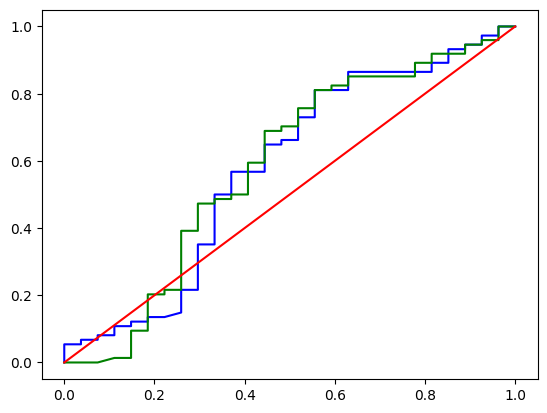

In [175]:
X = data1.loc[:,['year', 'age', 'nodes_detected']].values
y = data1.survival_status.replace(2, 0).values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.33, random_state=1)
n,p = X_train.shape

# logistic regression
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_mle, cov = NewtonRaphsonLogistReg(beta0, X_train, y_train, maxiter, tolerance)
predict_probs = sigma(X_test,beta_mle)

# LDA model
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True)
clf.fit(X_train, y_train)
clf.means_, clf.priors_, clf.covariance_
pred_probs_lda = clf.predict_proba(X_test)
pred_probs_lda.shape
pred_probs_lda = pred_probs_lda[:,1]

# log scoring rule 
LS_MLE = -(y_test.T.dot(np.log(predict_probs))+(1-y_test).T.dot(np.log(1-predict_probs)))
LS_LDA = -(y_test.T.dot(np.log(pred_probs_lda))+(1-y_test).T.dot(np.log(1-pred_probs_lda)))
print('log scoring rule in logistic regression and LDA')
print(LS_MLE, LS_LDA)

# roc curve
fpr,tpr,thresholds = roc_curve(y_test,predict_probs)
fpr2,tpr2,thresholds2 = roc_curve(y_test,pred_probs_lda)
xgrid = np.linspace(0,1,100) 
plt.plot(fpr,tpr, 'blue')
plt.plot(fpr2,tpr2, 'green')
plt.plot(xgrid,xgrid,'red')

# area under the roc
AUC_MLE = roc_auc_score(y_test,predict_probs)
AUC_LDA = roc_auc_score(y_test,pred_probs_lda)
print('area under the roc in logistic regression and LDA')
print(AUC_MLE, AUC_LDA)
